<a href="https://colab.research.google.com/github/zafe312/GW_from_domain_walls/blob/main/3D_DW_simulation_RD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python
"""
3D cosmological evolution equation solved by finite differences.
"""
import time, sys
import numpy as np
import os, psutil # for checking memory uses
import h5py

def mem():
  print(f' Memory in use is {int(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)} mb \n') # gives mb of memory uses

def solver(I, V, lam, eta, a0, Lx, Ly, Lz, Nx, Ny, Nz, dt, ti, T,
           user_action=None, version='scalar'):
    print(f'\nLattice size is {(Lx,Ly,Lz)} with {(Nx,Ny,Nz)} = {(Nx)*(Ny)*(Nz)} lattice points.')
    print(f'ti = {ti}, tf = {T}, dt = {dt}, Nt = {int(round(T/float(dt)))}\n')
    print('Initializing and performing 1st step...')
    
    if version == 'cython':
        try:
            #import pyximport; pyximport.install()
            import wave2D_u0_loop_cy as compiled_loops
            advance = compiled_loops.advance
        except ImportError as e:
            print ('No module wave2D_u0_loop_cy. Run make_wave2D.sh!')
            print (e)
            sys.exit(1)
    elif version == 'f77':
        try:
            import wave2D_u0_loop_f77 as compiled_loops
            advance = compiled_loops.advance
        except ImportError:
            print ('No module wave2D_u0_loop_f77. Run make_wave2D.sh!')
            sys.exit(1)
    elif version == 'c_f2py':
        try:
            import wave2D_u0_loop_c_f2py as compiled_loops
            advance = compiled_loops.advance
        except ImportError:
            print ('No module wave2D_u0_loop_c_f2py. Run make_wave2D.sh!')
            sys.exit(1)
    elif version == 'c_cy':
        try:
            import wave2D_u0_loop_c_cy as compiled_loops
            advance = compiled_loops.advance_cwrap
        except ImportError as e:
            print ('No module wave2D_u0_loop_c_cy. Run make_wave2D.sh!')
            print (e)
            sys.exit(1)
    elif version == 'vectorized':
        advance = advance_vectorized
    elif version == 'scalar':
        advance = advance_scalar

    x = np.linspace(0, Lx, Nx, endpoint=False)  # mesh points in x dir
    y = np.linspace(0, Ly, Ny, endpoint=False)  # mesh points in y dir
    z = np.linspace(0, Lz, Nz, endpoint=False)  # mesh points in y dir
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dz = z[1] - z[0]
    
    Bx = dt**2/(a0*dx)**2
    By = dt**2/(a0*dy)**2
    Bz = dt**2/(a0*dz)**2

    xv = x[:,np.newaxis,np.newaxis]          # for vectorized function evaluations
    yv = y[np.newaxis,:,np.newaxis]
    zv = z[np.newaxis,np.newaxis,:]

    stability_limit = (float(a0))*(1/np.sqrt(1/dx**2 + 1/dy**2))
    if dt <= 0:                # max time step?
        safety_factor = -dt    # use negative dt as safety factor
        dt = safety_factor*stability_limit
    elif dt > stability_limit:
        raise ValueError('error: dt=%g exceeds the stability limit %g' % \
              (dt, stability_limit))
        
    Nt = int(round(T/float(dt)))
    t = np.linspace(ti, ti+Nt*dt, Nt)    # mesh points in time
    dt2 = dt**2

    # Allow f and V to be None or 0
    if V is None or V == 0:
        V = (lambda x, y, z: 0) if version == 'scalar' else \
            lambda x, y, z: np.zeros((x.shape[0], y.shape[1], z.shape[2]))


    order = 'Fortran' if version == 'f77' else 'C'
    u   = np.zeros((Nx,Ny,Nz), order=order)   # solution array
    u[:,:,:]   = -1
    u_1 = np.zeros((Nx,Ny,Nz), order=order)   # solution at t-dt
    u_1[:,:,:] = -1
    u_2 = np.zeros((Nx,Ny,Nz), order=order)   # solution at t-2*dt
    u_2[:,:,:] = -1
    #f_a = np.zeros((Nx+1,Ny+1,Nz+1), order=order)   # for compiled loops

    Ix = range(0, u.shape[0])
    Iy = range(0, u.shape[1])
    Iz = range(0, u.shape[2])
    It = range(0, t.shape[0])

    import time; t0 = time.process_time()          # for measuring CPU time

    # Load initial condition into u_1
    if version == 'scalar':
        for i in Ix:
            for j in Iy:
                u_1[i,j] = I(x[i], y[j])
    else: # use vectorized version
        u_1[:,:,:] = I(xv, yv, zv)

    if user_action is not None:
        user_action(u_1, x, xv, y, yv, z, zv, t, 0)

    # Special formula for first time step
    n = 0
    # First step requires a special formula, use either the scalar
    # or vectorized version (the impact of more efficient loops than
    # in advance_vectorized is small as this is only one step)
    if version == 'scalar':
        u = advance_scalar(
            u, u_1, u_2, f, x, y, t, n,
            Cx2, Cy2, dt2, V, step1=True)

    else:
        V_a = V(xv, yv, zv)
        u = advance_vectorized(
            u, u_1, u_2, lam, n, eta, Bx, By, Bz, ti, dt2, V=V_a, step1=True)

    if user_action is not None:
        user_action(u, x, xv, y, yv, z, zv, t, 1)

    # Update data structures for next step
    #u_2[:] = u_1;  u_1[:] = u  # safe, but slower
    u_2, u_1, u = u_1, u, u_2
    
    print('Entering loop...')
    for n in It[1:-1]:
        iter_t0 = time.process_time() # check iteration time
        
        if version == 'scalar':
            # use f(x,y,t) function
            u = advance(u, u_1, u_2, f, x, y, t, n, Cx2, Cy2, dt2)
        else:
            u = advance(u, u_1, u_2, lam, n, eta, Bx, By, Bz, ti, dt2)

        if version == 'f77':
            for a in 'u', 'u_1', 'u_2', 'f_a':
                if not isfortran(eval(a)):
                    print ('%s: not Fortran storage!' % a)

        if user_action is not None:
            if user_action(u, x, xv, y, yv, z, zv, t, n+1):
                break

        # Update data structures for next step
        #u_2[:] = u_1;  u_1[:] = u  # safe, but slower
        u_2, u_1, u = u_1, u, u_2
        
        iter_t1 = time.process_time()
        iter_t = iter_t1 - iter_t0
        print(f'n = {n} iteration done in {round(iter_t,3)} sec.')

    # Important to set u = u_1 if u is to be returned!
    t1 = time.process_time()
    # dt might be computed in this function so return the value
    return dt, t1 - t0



def advance_scalar(u, u_1, u_2, f, x, y, t, n, Cx2, Cy2, dt2,
                   V=None, step1=False):
    Ix = range(0, u.shape[0]);  Iy = range(0, u.shape[1])
    if step1:
        dt = np.sqrt(dt2)  # save
        Cx2 = 0.5*Cx2;  Cy2 = 0.5*Cy2; dt2 = 0.5*dt2  # redefine
        D1 = 1;  D2 = 0
    else:
        D1 = 2;  D2 = 1
    for i in Ix[1:-1]:
        for j in Iy[1:-1]:
            u_xx = u_1[i-1,j] - 2*u_1[i,j] + u_1[i+1,j]
            u_yy = u_1[i,j-1] - 2*u_1[i,j] + u_1[i,j+1]
            u[i,j] = D1*u_1[i,j] - D2*u_2[i,j] + \
                     Cx2*u_xx + Cy2*u_yy + dt2*f(x[i], y[j], t[n])
            if step1:
                u[i,j] += dt*V(x[i], y[j])
    # Boundary condition u=0
    j = Iy[0]
    for i in Ix: u[i,j] = 0
    j = Iy[-1]
    for i in Ix: u[i,j] = 0
    i = Ix[0]
    for j in Iy: u[i,j] = 0
    i = Ix[-1]
    for j in Iy: u[i,j] = 0
    return u

def advance_vectorized(u, u_1, u_2, lam, n, eta, Bx, By, Bz, ti, dt2,
                       V=None, step1=False):
    dt = np.sqrt(dt2)  # save
    Bx = Bx/(n*dt+ti); By = By/(n*dt+ti); Bz = Bz/(n*dt+ti)
    A = dt/(2*(ti+n*dt))

    u_xx = u_1[:-2,1:-1,1:-1] - 2*u_1[1:-1,1:-1,1:-1] + u_1[2:,1:-1,1:-1]
    u_yy = u_1[1:-1,:-2,1:-1] - 2*u_1[1:-1,1:-1,1:-1] + u_1[1:-1,2:,1:-1]
    u_zz = u_1[1:-1,1:-1,:-2] - 2*u_1[1:-1,1:-1,1:-1] + u_1[1:-1,1:-1,2:]
    
    if step1:
        u[1:-1,1:-1,1:-1] = (1 - ((lam*dt2)/2)*(u_1[1:-1,1:-1,1:-1]*u_1[1:-1,1:-1,1:-1] - \
                       eta**2))*u_1[1:-1,1:-1,1:-1] - ((3/2)*A-1)*dt*V[1:-1,1:-1,1:-1] + \
                       Bx*u_xx/2 + By*u_yy/2 + Bz*u_zz/2
    else:
        u[1:-1,1:-1,1:-1] = ((2 - lam*dt2*(u_1[1:-1,1:-1,1:-1]*u_1[1:-1,1:-1,1:-1] - \
                       eta**2))*u_1[1:-1,1:-1,1:-1] + ((3/2)*A-1)*u_2[1:-1,1:-1,1:-1] + \
                       Bx*u_xx + By*u_yy + Bz*u_zz)/(1+(3/2)*A)

    # Boundary condition u=0
    Bxx = np.sqrt(Bx/3)
    Byy = np.sqrt(By/3)
    Bzz = np.sqrt(Bz/3)
    tol_bc = 1e-4

    k = 0
    u[:,:,k] = -1
#     if abs(u[:,:,u.shape[2]-1].max()+1) > tol_bc:
#         u[:,:,k] = u[:,:,u.shape[2]-1]
#     else:
#         u[:,:,k] = -1
    k = u.shape[2] - 1
    u[:,:,k] = -1
#     u[0,0,k] = u_1[0,0,k] - Bxx*(u_1[0,0,k] - u_1[1,0,k]) - Byy*(u_1[0,0,k] - u_1[0,1,k]) - Bzz*(u_1[0,0,k] - u_1[0,0,k-1])
#     u[0,1:,k] = u_1[0,1:,k] - Bxx*(u_1[0,1:,k] - u_1[1,1:,k]) - Byy*(u_1[0,1:,k] - u_1[0,:-1,k]) - Bzz*(u_1[0,1:,k] - u_1[0,1:,k-1])
#     u[1:,0,k] = u_1[1:,0,k] - Bxx*(u_1[1:,0,k] - u_1[:-1,0,k]) - Byy*(u_1[1:,0,k] - u_1[1:,1,k]) - Bzz*(u_1[1:,0,k] - u_1[1:,0,k-1])
#     u[1:,1:,k] = u_1[1:,1:,k] - Bxx*(u_1[1:,1:,k] - u_1[:-1,1:,k]) - Byy*(u_1[1:,1:,k] - u_1[1:,:-1,k]) - Bzz*(u_1[1:,1:,k] - u_1[1:,1:,k-1])

    j = 0
    u[:,j,:] = -1
#     if abs(u[:,u.shape[1]-1,:].max()+1) > tol_bc:
#         u[:,j,:] = u[:,u.shape[1]-1,:]
#     else:
#         u[:,j,:] = -1.0
    j = u.shape[1]-1
    u[:,j,:] = -1
#     u[0,j,0] = u_1[0,j,0] - Bxx*(u_1[0,j,0] - u_1[1,j,0]) - Byy*(u_1[0,j,0] - u_1[0,j-1,0]) - Bzz*(u_1[0,j,0] - u_1[0,j,1])
#     u[0,j,1:] = u_1[0,j,1:] - Bxx*(u_1[0,j,1:] - u_1[1,j,1:]) - Byy*(u_1[0,j,1:] - u_1[0,j-1,1:]) - Bzz*(u_1[0,j,1:] - u_1[0,j,:-1])
#     u[1:,j,0] = u_1[1:,j,0] - Bxx*(u_1[1:,j,0] - u_1[:-1,j,0]) - Byy*(u_1[1:,j,0] - u_1[1:,j-1,0]) - Bzz*(u_1[1:,j,0] - u_1[1:,j,1])
#     u[1:,j,1:] = u_1[1:,j,1:] - Bxx*(u_1[1:,j,1:] - u_1[:-1,j,1:]) - Byy*(u_1[1:,j,1:] - u_1[1:,j-1,1:]) - Bzz*(u_1[1:,j,1:] - u_1[1:,j,:-1])
    
    i = 0
    u[i,:,:] = -1
#     if abs(u[u.shape[0]-1,:,:].max()+1) > tol_bc:
#         u[i,:,:] = u[u.shape[0]-1,:,:]
#     else:
#         u[i,:,:] = -1.0
    i = u.shape[0] - 1
    u[i,:,:] = -1
#     u[i,0,0] = u_1[i,0,0] - Bxx*(u_1[i,0,0] - u_1[i-1,0,0]) - Byy*(u_1[i,0,0] - u_1[i,1,0]) - Bzz*(u_1[i,0,0] - u_1[i,0,1])
#     u[i,0,1:] = u_1[i,0,1:] - Bxx*(u_1[i,0,1:] - u_1[i-1,0,1:]) - Byy*(u_1[i,0,1:] - u_1[i,1,1:]) - Bzz*(u_1[i,0,1:] - u_1[i,0,:-1])
#     u[i,1:,0] = u_1[i,1:,0] - Bxx*(u_1[i,1:,0] - u_1[i-1,1:,0]) - Byy*(u_1[i,1:,0] - u_1[i,:-1,0]) - Bzz*(u_1[i,1:,0] - u_1[i,1:,1])
#     u[i,1:,1:] = u_1[i,1:,1:] - Bxx*(u_1[i,1:,1:] - u_1[i-1,1:,1:]) - Byy*(u_1[i,1:,1:] - u_1[i,:-1,1:]) - Bzz*(u_1[i,1:,1:] - u_1[i,1:,:-1])
    return u

def quadratic(Nx, Ny, version):
    """Exact discrete solution of the scheme."""

    def exact_solution(x, y, t):
        return x*(Lx - x)*y*(Ly - y)*(1 + 0.5*t)

    def I(x, y):
        return exact_solution(x, y, 0)

    def V(x, y):
        return 0.5*exact_solution(x, y, 0)

    def f(x, y, t):
        return 2*c**2*(1 + 0.5*t)*(y*(Ly - y) + x*(Lx - x))

    Lx = 5;  Ly = 2
    c = 1.5
    dt = -1 # use longest possible steps
    T = 18

    def assert_no_error(u, x, xv, y, yv, t, n):
        u_e = exact_solution(xv, yv, t[n])
        diff = abs(u - u_e).max()
        tol = 1E-12
        msg = 'diff=%g, step %d, time=%g' % (diff, n, t[n])
        assert diff < tol, msg

    new_dt, cpu = solver(
        I, V, f, c, Lx, Ly, Nx, Ny, dt, T,
        user_action=assert_no_error, version=version)
    return new_dt, cpu


def test_quadratic():
    # Test a series of meshes where Nx > Ny and Nx < Ny
    versions = 'scalar', 'vectorized' # , 'cython', 'f77', 'c_cy', 'c_f2py'
    for Nx in range(2, 6, 2):
        for Ny in range(2, 6, 2):
            for version in versions:
                print ('testing', version, 'for %dx%d mesh' % (Nx, Ny))
                new_dt, cpu = quadratic(Nx, Ny, version)
                print(f'new_dt = {new_dt} and cpu = {cpu}\n')

def run_efficiency(nrefinements=4):
    def I(x, y):
        return sin(pi*x/Lx)*sin(pi*y/Ly)

    Lx = 10;  Ly = 10
    c = 1.5
    T = 100
    versions = ['scalar', 'vectorized', 'cython', 'f77',
               'c_f2py', 'c_cy']
    print (' '*15, ''.join(['%-13s' % v for v in versions]))
    for Nx in 15, 30, 60, 120:
        cpu = {}
        for version in versions:
            dt, cpu_ = solver(I, None, None, c, Lx, Ly, Nx, Nx,
                              -1, T, user_action=None,
                              version=version)
            cpu[version] = cpu_
        cpu_min = min(list(cpu.values()))
        if cpu_min < 1E-6:
            print ('Ignored %dx%d grid (too small execution time)' \
                  % (Nx, Nx))
        else:
            cpu = {version: cpu[version]/cpu_min for version in cpu}
            print ('%-15s' % '%dx%d' % (Nx, Nx),)
            print (''.join(['%13.1f' % cpu[version] for version in versions]))

def model(plot_method=3, version='vectorized', save_plot=True, T=1):
    """
    Defines initial field config, model parameters, grid parameters and calls solver function.
    plot_method=1 applies mesh function, =2 means surf, =0 means no plot.
    """
    # Clean up plot files
    import glob, os
    for name in glob.glob('tmp_*.png'):
        os.remove(name)
    for name in glob.glob('field_*.h5'):
        os.remove(name)
    if glob.glob('geekfile.txt'):
        os.remove('geekfile.txt')

    # Grid and model parameters
    Lx = 50; Ly = 50; Lz = 50;
    Nx = 256; Ny = 256; Nz = 256; ti = 1; T = T; dt = 1e-1
    lam = 0.1; eta = 1; a0 = 1
    Bx = 1; By = 1; Bz = 1

    def I(x, y, z):
        """Initial field configuration."""
#         return np.exp(-0.5*(x-Lx/2.0)**2 - 0.5*(y-Ly/2.0)**2) # Gaussian peak at the centre
        return -np.tanh((np.sqrt((x-Lx/2)**2+(y-Ly/2)**2+(z-Lz/2)**2)-Lx/4)/2) # tanh sphere at the centre
        
    
    def V(x, y, z):
        return (y-x-z)*0


    def plot_u(u, x, xv, y, yv, z, zv, t, n):
        if t[n] == 0:
            time.sleep(2)
        if plot_method == 1:
            mesh(x, y, u, title='t=%g' % t[n], zlim=[-1,1],
                 caxis=[-1,1])
            
        elif plot_method == 2:
            import matplotlib.pyplot as plt
#             fig, ax = plt.figure()
            fig, ax = plt.subplots(figsize=(6,6))
            u_surf = ax.contourf(x,y,u)
#             plt.xlabel('x')
#             plt.ylabel('y')
            ax.set_title('Contour Plot')
#             plt.colorbar()
            #cont_plot(x, y, u)
            
        elif plot_method == 3:
            from mpl_toolkits import mplot3d
            import matplotlib.pyplot as plt

            fig = plt.figure()
            ax = plt.axes(projection='3d')

            u_surf = ax.plot_surface(xv[:,:,0], yv[:,:,0], u[:,:,int(Nz/2)],cmap='viridis', edgecolor='none')
            title = f'n = {n}, t = {round(ti+n*dt,3)}, tau = {round(2*np.sqrt(ti+n*dt),3)}'
            ax.set_title(title)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel(f'$\phi(x,y,{round(Nz/2*(zv[0,0,1]-zv[0,0,0]),1)})$')
            ax.set_zlim(-2, 2)
            
        if plot_method > 0:
            time.sleep(0) # pause between frames
            filename = 'field_%04d.h5' % n
            # save array into gz file
            #u_reshaped = u.reshape(u.shape[0], -1)
            #np.savetxt(filename, u_reshaped) # most time consuming step
            def hdf5_write(data,name):
                f = h5py.File(name, "w")
                f.create_dataset('data', data=data)
            hdf5_write(u,filename)           
            if save_plot:
                filename = 'tmp_%04d.png' % n
                plt.savefig(filename)  # time consuming!
            ax.collections.remove(u_surf)
            plt.close('all')
            plt.draw()
            time.sleep(1)

    dt, cpu = solver(I, V, lam, eta, a0, Lx, Ly, Lz, Nx, Ny, Nz, dt, ti, T,
                     user_action=plot_u, version=version)
    print(f'Total time taken is {cpu/3600} hr')
    
    # Make video files
    fps = 4  # frames per second
    codec2ext = dict(flv='flv', libx264='mp4', libvpx='webm',
                     libtheora='ogg')  # video formats
    filespec = 'tmp_%04d.png'
    movie_program = 'ffmpeg'  # or 'avconv'
    for codec in codec2ext:
        ext = codec2ext[codec]
        cmd = '%(movie_program)s -r %(fps)d -i %(filespec)s '\
              '-vcodec %(codec)s movie.%(ext)s' % vars()
        os.system(cmd)




if __name__ == '__main__':
    #test_quadratic()
    mem()
    model(T=50)
    mem()

 Memory in use is 119 mb 


Lattice size is (50, 50, 50) with (256, 256, 256) = 16777216 lattice points.
ti = 1, tf = 50, dt = 0.1, Nt = 500

Initializing and performing 1st step...
Entering loop...
n = 1 iteration done in 1.673 sec.
n = 2 iteration done in 1.753 sec.
n = 3 iteration done in 1.848 sec.
n = 4 iteration done in 2.055 sec.
n = 5 iteration done in 1.729 sec.
n = 6 iteration done in 1.87 sec.
n = 7 iteration done in 1.691 sec.
n = 8 iteration done in 1.991 sec.
n = 9 iteration done in 1.872 sec.
n = 10 iteration done in 1.818 sec.
n = 11 iteration done in 1.758 sec.
n = 12 iteration done in 2.033 sec.
n = 13 iteration done in 1.885 sec.
n = 14 iteration done in 1.927 sec.
n = 15 iteration done in 1.839 sec.
n = 16 iteration done in 2.031 sec.
n = 17 iteration done in 1.794 sec.
n = 18 iteration done in 2.118 sec.
n = 19 iteration done in 1.763 sec.
n = 20 iteration done in 1.981 sec.
n = 21 iteration done in 1.845 sec.
n = 22 iteration done in 1.786 sec.
n = 23 iteration do

<Figure size 432x288 with 0 Axes>

## GW **CALCULATION**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.fft import fft2, fftfreq, fftn, ifftn, fftshift
from scipy.integrate import simps as simpson
import scipy.special as spl
import time
import os, psutil
import h5py
import gc

def mem():
  print(f'Memory in use is {int(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)} mb') # gives mb of memory uses
mem()

Memory in use is 139 mb


In [2]:
# params
Lx = 50
Ly = 50
Lz = 50
Nx = 256
Ny = 256
Nz = 256
dt = 1e-1
ti = 1
Nt = 500
skip_factor = 1
reduced_steps = int(Nt/skip_factor)
print(reduced_steps)
T = ti + (dt*Nt)

# Grid
x = np.linspace(0, Lx, Nx+1, endpoint=False)  # mesh points in x dir
y = np.linspace(0, Ly, Ny+1, endpoint=False)  # mesh points in y dir
z = np.linspace(0, Lz, Nz+1, endpoint=False)  # mesh points in z dir
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

# xv = x[:,np.newaxis,np.newaxis]          # for vectorized function evaluations
# yv = y[np.newaxis,:,np.newaxis]
# zv = z[np.newaxis,np.newaxis,:]
xv, yv, zv = np.meshgrid(x,y,z, indexing='ij')

# cosmological parameters
def a(n):
    return np.sqrt(ti + n*dt)

def H(n):
    return 0.5/a(n)**2

eta = 1
beta = 1/2
alpha = beta/(1-beta)
v = alpha - 1/2

t = np.linspace(ti, T, Nt)
tau = t**(1-beta)/(1-beta)
mem()

500
Memory in use is 528 mb


In [3]:
def FT(n, uxx=0,uxy=0,uxz=0,uyy=0,uyz=0,uzz=0,N=np.nan):
    '''
        Gives the fourier transform of energy-momentum tensor
    '''
    if not isinstance(uxx, np.ndarray) or not isinstance(uxy, np.ndarray) or not isinstance(uxz, np.ndarray) or not isinstance(uyy, np.ndarray) or not isinstance(uyz, np.ndarray) or not isinstance(uzz, np.ndarray):
        filename = 'field_%04d.h5' % n
        #u = np.genfromtxt(filename)
        #u = u.reshape(u.shape[0],u.shape[1] // (Nz), Nz)
        u = h5py.File(filename, 'r')
        #u = np.array(u5['data'])
        #u5.close()

        ux = np.gradient(u['data'], axis = 0)/dx
        uy = np.gradient(u['data'], axis = 1)/dy
        uz = np.gradient(u['data'], axis = 2)/dz
        u.close()
        uxx = ux * ux
        uxy = ux * uy
        uxz = ux * uz
        uyy = uy * uy
        uyz = uy * uz
        uzz = uz * uz

    # Fourier transform
    uxx_ft = fftshift(fftn(uxx))
    uxy_ft = fftshift(fftn(uxy))
    uxz_ft = fftshift(fftn(uxy))
    uyy_ft = fftshift(fftn(uyy))
    uyz_ft = fftshift(fftn(uyz))
    uzz_ft = fftshift(fftn(uzz))
    
    # Fourier frequencies
    if not np.isnan(N):
        kx = fftfreq(N,Lx/N)
        ky = fftfreq(N,Ly/N)
        kz = fftfreq(N,Ly/N)
    else:
        kx = fftshift(fftfreq(Nx,Lx/(Nx)))
        ky = fftshift(fftfreq(Ny,Ly/(Ny)))
        kz = fftshift(fftfreq(Nz,Lz/(Nz)))
        N = Nz
        
    kx, ky, kz = np.meshgrid(kx,ky,kz,indexing='ij')
    kx = kx*(2*np.pi)
    ky = ky*(2*np.pi)
    kz = kz*(2*np.pi)

    # visualization
    def viz():
        import matplotlib.cm as cm
        f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,8), sharex=False, sharey=False)
        #ax1.imshow(uxx, cmap=cm.Reds)
        ax1.contourf(uxx[:,:,int(N/2)])
        #ax4.imshow(np.real(uxx_ft), cmap=cm.Reds)
        ax4.contourf(kx[:,:,int(N/2)],ky[:,:,int(N/2)],np.abs(uxx_ft)[:,:,int(N/2)])
        #ax2.imshow(uxy, cmap=cm.Reds)
        ax2.contourf(uxy[:,:,int(N/2)])
        #ax5.imshow(np.real(uxy_ft), cmap=cm.Reds)
        ax5.contourf(kx[:,:,int(N/2)],ky[:,:,int(N/2)],np.abs(uxy_ft)[:,:,int(N/2)])
        #ax3.imshow(uyy, cmap=cm.Reds)
        ax3.contourf(uyy[:,:,int(N/2)])
        #ax6.imshow(np.real(uyy_ft), cmap=cm.Reds)
        ax6.contourf(kx[:,:,int(N/2)],ky[:,:,int(N/2)],np.abs(uyy_ft)[:,:,int(N/2)])
    #viz()
    return uxx_ft, uxy_ft, uxz_ft, uyy_ft, uyz_ft, uzz_ft, kx, ky, kz

mem()

Memory in use is 528 mb


2.965726674999985

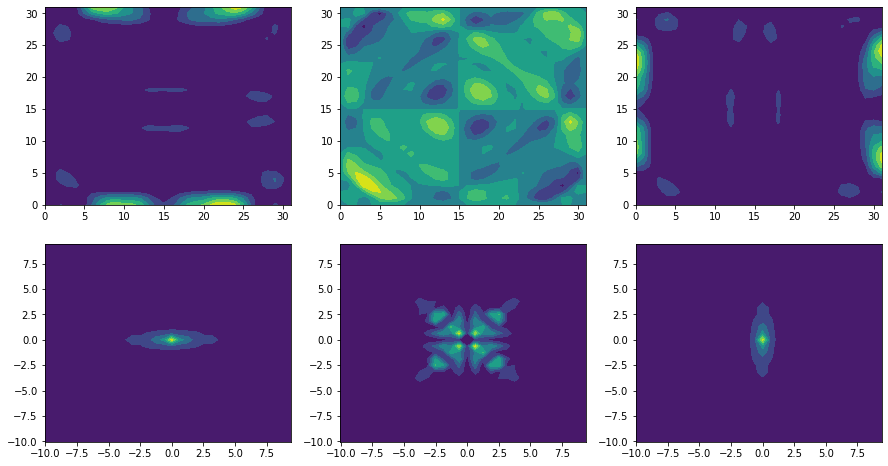

In [ ]:
tft0 = time.process_time()
_,_,_,_,_,_,kx,ky,kz = FT(400)
tft1 = time.process_time()
tft1-tft0

In [4]:
def project(uxx=0,uxy=0,uxz=0,uyy=0,uyz=0,uzz=0,k_vec=np.array([0,0,1])):
    '''
    Returns TT part of the emergy-momentum tensor.
    input: 6 fourier transform arrays uxx, uxy, uxz, uyy, uyz, uzz and np array k with shape (3,)
    output: T, np array with shape (3,3)
    '''
    if np.linalg.norm(k_vec):
        k_hat = k_vec / np.linalg.norm(k_vec)
    else:
        k_hat = np.array([0,0,0])
    P = np.identity(3) - np.outer(k_hat,k_hat)
    Oxxxx = P[0,0]*P[0,0] - 0.5*P[0,0]*P[0,0]
    Oxxxy = P[0,0]*P[0,1] - 0.5*P[0,0]*P[0,1]
    Oxxxz = P[0,0]*P[0,2] - 0.5*P[0,0]*P[0,2]
    Oxxyy = P[0,1]*P[0,1] - 0.5*P[0,0]*P[1,1]
    Oxxyz = P[0,1]*P[0,2] - 0.5*P[0,0]*P[1,2]
    Oxxzz = P[0,2]*P[0,2] - 0.5*P[0,0]*P[2,2]
    
    Oxyxx = P[0,0]*P[1,0] - 0.5*P[0,1]*P[0,0]
    Oxyxy = P[0,0]*P[1,1] - 0.5*P[0,1]*P[0,1]
    Oxyxz = P[0,0]*P[1,1] - 0.5*P[0,1]*P[0,1]
    Oxyyy = P[0,1]*P[1,1] - 0.5*P[0,1]*P[1,1]
    Oxyyz = P[0,1]*P[1,2] - 0.5*P[0,1]*P[1,2]
    Oxyzz = P[0,2]*P[1,2] - 0.5*P[0,1]*P[2,2]
    
    Oxzxx = P[0,0]*P[2,0] - 0.5*P[0,2]*P[0,0]
    Oxzxy = P[0,0]*P[2,1] - 0.5*P[0,2]*P[0,1]
    Oxzxz = P[0,0]*P[2,2] - 0.5*P[0,2]*P[0,2]
    Oxzyy = P[0,1]*P[2,1] - 0.5*P[0,2]*P[1,1]
    Oxzyz = P[0,1]*P[2,2] - 0.5*P[0,2]*P[1,2]
    Oxzzz = P[0,2]*P[2,2] - 0.5*P[0,2]*P[2,2]
    
    Oyyxx = P[1,0]*P[1,0] - 0.5*P[1,1]*P[0,0]
    Oyyxy = P[1,0]*P[1,1] - 0.5*P[1,1]*P[0,1]
    Oyyxz = P[1,0]*P[1,2] - 0.5*P[1,1]*P[0,2]
    Oyyyy = P[1,1]*P[1,1] - 0.5*P[1,1]*P[1,1]
    Oyyyz = P[1,1]*P[1,2] - 0.5*P[1,1]*P[1,2]
    Oyyzz = P[1,2]*P[1,2] - 0.5*P[1,1]*P[2,2]
    
    Oyzxx = P[1,0]*P[2,0] - 0.5*P[1,2]*P[0,0]
    Oyzxy = P[1,0]*P[2,1] - 0.5*P[1,2]*P[0,1]
    Oyzxz = P[1,0]*P[2,2] - 0.5*P[1,2]*P[0,2]
    Oyzyy = P[1,1]*P[2,1] - 0.5*P[1,2]*P[1,1]
    Oyzyz = P[1,1]*P[2,2] - 0.5*P[1,2]*P[1,2]
    Oyzzz = P[1,2]*P[2,2] - 0.5*P[1,2]*P[2,2]
    
    Ozzxx = P[2,0]*P[2,0] - 0.5*P[2,2]*P[0,0]
    Ozzxy = P[2,0]*P[2,1] - 0.5*P[2,2]*P[0,1]
    Ozzxz = P[2,0]*P[2,2] - 0.5*P[2,2]*P[0,2]
    Ozzyy = P[2,1]*P[2,1] - 0.5*P[2,2]*P[1,1]
    Ozzyz = P[2,1]*P[2,2] - 0.5*P[2,2]*P[1,2]
    Ozzzz = P[2,2]*P[2,2] - 0.5*P[2,2]*P[2,2]

    Txx = Oxxxx*uxx + 2*Oxxxy*uxy + 2*Oxxxz*uxz + Oxxyy*uyy + 2*Oxxyz*uyz + Oxxzz+uzz
    Txy = Oxyxx*uxx + 2*Oxyxy*uxy + 2*Oxyxz*uxz + Oxyyy*uyy + 2*Oxyyz*uyz + Oxyzz+uzz
    Txz = Oxzxx*uxx + 2*Oxzxy*uxy + 2*Oxzxz*uxz + Oxzyy*uyy + 2*Oxzyz*uyz + Oxzzz+uzz
    Tyy = Oyyxx*uxx + 2*Oyyxy*uxy + 2*Oyyxz*uxz + Oyyyy*uyy + 2*Oyyyz*uyz + Oyyzz+uzz
    Tyz = Oyzxx*uxx + 2*Oyzxy*uxy + 2*Oyzxz*uxz + Oyzyy*uyy + 2*Oyzyz*uyz + Oyzzz+uzz
    Tzz = Ozzxx*uxx + 2*Ozzxy*uxy + 2*Ozzxz*uxz + Ozzyy*uyy + 2*Ozzyz*uyz + Ozzzz+uzz
    
    return Txx, Txy, Txz, Tyy, Tyz, Tzz

mem()

Memory in use is 528 mb


In [5]:
def multiply_factors(K, n,Txx, Txy, Txz, Tyy, Tyz, Tzz):
    '''Multiplies a tensor with the appropriate Bessel and Neumann factors for the time integration.'''
    x = K*tau[n]
    if not x:
        x = 1e-2 # neumann functio is -inf for x = 0

    Txx_J = np.sqrt(x)*a(x)*spl.jv(v,x)*Txx
    Txy_J = np.sqrt(x)*a(x)*spl.jv(v,x)*Txy
    Txz_J = np.sqrt(x)*a(x)*spl.jv(v,x)*Txz
    Tyy_J = np.sqrt(x)*a(x)*spl.jv(v,x)*Tyy
    Tyz_J = np.sqrt(x)*a(x)*spl.jv(v,x)*Tyz
    Tzz_J = np.sqrt(x)*a(x)*spl.jv(v,x)*Tzz
    Txx_N = np.sqrt(x)*a(x)*spl.yv(v,x)*Txx
    Txy_N = np.sqrt(x)*a(x)*spl.yv(v,x)*Txy
    Txz_N = np.sqrt(x)*a(x)*spl.yv(v,x)*Txz
    Tyy_N = np.sqrt(x)*a(x)*spl.yv(v,x)*Tyy
    Tyz_N = np.sqrt(x)*a(x)*spl.yv(v,x)*Tyz
    Tzz_N = np.sqrt(x)*a(x)*spl.yv(v,x)*Tzz
    
    return Txx_J, Txy_J, Txz_J, Tyy_J, Tyz_J, Tzz_J, Txx_N, Txy_N, Txz_N, Tyy_N, Tyz_N, Tzz_N

mem()

Memory in use is 528 mb


In [6]:
_,_,_,_,_,_,kx,ky,kz = FT(2) # Find kx and ky

Nk = 100 # no of k points
k_max = np.sqrt(kx[0,:,:].max()**2 + ky[:,0,:].max()**2 + kz[:,:,0].max()**2)/np.sqrt(3)
k_full_range = np.linspace(0,k_max,Nk)
dk = k_full_range[1] - k_full_range[0]

print('kmax = ', k_max)

# define spherical co-ordinates
# kxv, kyv, kzv = np.meshgrid(k_full_range,k_full_range,k_full_range,indexing='ij')
R = np.sqrt(kx**2 + ky**2 + kz**2)
kxky = np.sqrt(kx**2 + ky**2)
Theta = np.arctan2(kxky,kz)
Phi = np.arctan2(ky,kx)
Phi[Phi < 0] = 2*np.pi + Phi[Phi < 0]
Phi[0,0,:] = 0
print(Theta.shape)

del kx, ky, kz
gc.collect()

mem()

kmax =  16.084954386379742
(256, 256, 256)
Memory in use is 3860 mb


In [7]:
# Define k vector i.e. direction of propagation
K = 10
theta = 0
phi = 0

def cal_en_den_tensor(K): # calculate gw energy density tensor for a certain k value
    Txx_J_sim = 0
    Txy_J_sim = 0
    Txz_J_sim = 0
    Tyy_J_sim = 0
    Tyz_J_sim = 0
    Tzz_J_sim = 0

    Txx_N_sim = 0
    Txy_N_sim = 0
    Txz_N_sim = 0
    Tyy_N_sim = 0
    Tyz_N_sim = 0
    Tzz_N_sim = 0
    
    print('Doing angular calculation...')
    
    k_vec = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), np.sin(theta)])

    for n in np.linspace(0,Nt-1,Nt)[::skip_factor]:
        t0 = time.process_time()
        n = int(n)
        uxx, uxy, uxz, uyy, uyz, uzz, _, _, _ = FT(n)
        uxx, uxy, uxz, uyy, uyz, uzz = project(uxx, uxy, uxz, uyy, uyz, uzz, k_vec)
        Txx_J, Txy_J, Txz_J, Tyy_J, Tyz_J, Tzz_J, Txx_N, Txy_N, Txz_N, Tyy_N, Tyz_N, Tzz_N = multiply_factors(K, n, uxx, uxy, uxz, uyy, uyz, uzz)

        del uxx, uxy, uxz, uyy, uyz, uzz
        gc.collect()

        # simpsons 3/8th rule
        if not n or n == np.linspace(0,Nt-1,Nt)[::skip_factor][-1]:
          weight = K/t[n]**beta
        elif n % 3 == 0:
          weight = 2*K/t[n]**beta
        else:
          weight = 3*K/t[n]**beta

        Txx_J_sim += weight * Txx_J
        Txy_J_sim += weight * Txy_J
        Txz_J_sim += weight * Txz_J
        Tyy_J_sim += weight * Tyy_J
        Tyz_J_sim += weight * Tyz_J
        Tzz_J_sim += weight * Tzz_J
        Txx_N_sim += weight * Txx_N
        Txy_N_sim += weight * Txy_N
        Txz_N_sim += weight * Txz_N
        Tyy_N_sim += weight * Tyy_N
        Tyz_N_sim += weight * Tyz_N
        Tzz_N_sim += weight * Tzz_N

        del Txx_J, Txy_J, Txz_J, Tyy_J, Tyz_J, Tzz_J, Txx_N, Txy_N, Txz_N, Tyy_N, Tyz_N, Tzz_N
        gc.collect()

        t1 = time.process_time()

        print(f'iteration for n = {n} done in {round(t1-t0,2)} sec.')
        mem()                                                                                                                            

    h = (t[::skip_factor][1] - t[::skip_factor][0])
    print('\n h = ', h)

    Txx_J_sim *= 3*h/8
    Txy_J_sim *= 3*h/8
    Txz_J_sim *= 3*h/8
    Tyy_J_sim *= 3*h/8
    Tyz_J_sim *= 3*h/8
    Tzz_J_sim *= 3*h/8
    Txx_N_sim *= 3*h/8
    Txy_N_sim *= 3*h/8
    Txz_N_sim *= 3*h/8
    Tyy_N_sim *= 3*h/8
    Tyz_N_sim *= 3*h/8
    Tzz_N_sim *= 3*h/8
            
    Txx_J_sim = np.abs(Txx_J_sim)**2
    Txy_J_sim = np.abs(Txy_J_sim)**2
    Txz_J_sim = np.abs(Txz_J_sim)**2
    Tyy_J_sim = np.abs(Tyy_J_sim)**2
    Tyz_J_sim = np.abs(Tyz_J_sim)**2
    Tzz_J_sim = np.abs(Tzz_J_sim)**2
    Txx_N_sim = np.abs(Txx_N_sim)**2
    Txy_N_sim = np.abs(Txy_N_sim)**2
    Txz_N_sim = np.abs(Txz_N_sim)**2
    Tyy_N_sim = np.abs(Tyy_N_sim)**2
    Tyz_N_sim = np.abs(Tyz_N_sim)**2
    Tzz_N_sim = np.abs(Tzz_N_sim)**2

    T2 = Txx_J_sim + Txx_N_sim + Tyy_J_sim + Tyy_N_sim + Tzz_J_sim + Tzz_N_sim + 2*( Txy_J_sim + Txy_N_sim + Txz_J_sim + Txz_N_sim + Tyz_J_sim + Tyz_N_sim)

    del Txx_J_sim, Txy_J_sim, Txz_J_sim, Tyy_J_sim, Tyz_J_sim, Tzz_J_sim, Txx_N_sim, Txy_N_sim, Txz_N_sim, Tyy_N_sim, Tyz_N_sim, Tzz_N_sim
    gc.collect()
        
    T2 = T2*np.sin(Theta) # for angular integration

    print(f'k = {K}, theta = {theta}, phi = {phi}, time steps = {reduced_steps}')
    mem()
    return T2

T2 = cal_en_den_tensor(K)

spec = []
kmaxx = k_max # change kmaxx and Nkk for checking custom k range
Nkk = 1000
k_range = np.linspace(0,kmaxx,Nkk)
# k_range = np.logspace(-2,1,Nkk)
tol = (k_range[1:]-k_range[:-1]) * 10

# angular integration using monte-carlo method
for i, r in enumerate(k_range[:-1]):
  Tr = T2[abs(R-r)<=tol[i]] # 1D array
  if not Tr.shape[0]:
    spec.append(spec[-1])
  else:
    spec.append(4*np.pi/Tr.shape[0] * Tr.sum())
  print(f'r = {round(r,3)} step done with {Tr.shape[0]} lattice points. Tolerance = {round(tol[i],3)}')

G = sc.constants.G
nn = int(np.linspace(0,Nt-1,Nt)[::skip_factor][-1])
multiplier = 2*G**2*k_range[:-1]/(3*Lx*Ly*Lz*a(nn)**4*H(nn)**2)
spec *= multiplier

const_norm = 8*np.pi*G**2*eta**4/(3*beta**2)
spec_normalised = spec/const_norm

Doing angular calculation...
iteration for n = 0 done in 10.56 sec.
Memory in use is 7961 mb
iteration for n = 1 done in 10.56 sec.
Memory in use is 9625 mb
iteration for n = 2 done in 9.86 sec.
Memory in use is 9625 mb
iteration for n = 3 done in 9.93 sec.
Memory in use is 9625 mb
iteration for n = 4 done in 9.81 sec.
Memory in use is 9625 mb
iteration for n = 5 done in 9.87 sec.
Memory in use is 9625 mb
iteration for n = 6 done in 9.71 sec.
Memory in use is 9625 mb
iteration for n = 7 done in 9.82 sec.
Memory in use is 9625 mb
iteration for n = 8 done in 9.87 sec.
Memory in use is 9626 mb
iteration for n = 9 done in 10.03 sec.
Memory in use is 9499 mb
iteration for n = 10 done in 11.48 sec.
Memory in use is 9309 mb
iteration for n = 11 done in 12.02 sec.
Memory in use is 9368 mb
iteration for n = 12 done in 11.55 sec.
Memory in use is 9369 mb
iteration for n = 13 done in 11.62 sec.
Memory in use is 9332 mb
iteration for n = 14 done in 11.6 sec.
Memory in use is 9370 mb
iteration for 

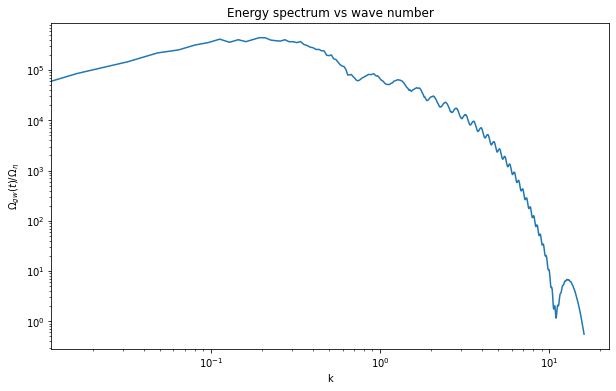

In [9]:
plt.figure(figsize = (10,6))
plt.plot(k_range[:-1],spec_normalised)
plt.loglog()
# plt.xlim([0.1,50])
plt.xlabel('k')
plt.ylabel('$\Omega_{gw}(t)/\Omega_{\eta}$')
plt.title('Energy spectrum vs wave number')
plt.show()

def save_spectrum():
# Clean up plot files
    import glob, os
    name = 'spectrum.png'
    if glob.glob(name):
      os.remove(name)
      plt.savefig(name)
save_spectrum()